## Import modules

In [2]:
import collections
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from configs.utils import get_dataset_dir
import sys
from analyze_stuff import get_config, get_dataloader
from tabulate import tabulate

## Util functions

In [3]:
from dis import show_code
import os
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np


def read_images(path):
    images = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename))
        if img is not None:
            images.append(img)
    return images


def read_annotation(path):
    with open(path) as f:
        data = json.load(f)
    return data


def create_histogram(
    dictionary,
    title,
    x_label="",
    y_label="",
    xtick_rotation=None,
    xtick_fontsize=None,
    ytick_rotation=None,
    ytick_fontsize=None,
    show=False,
    savefig_location=None,
    figsize=None,
    squeeze=None,
):
    names = list(dictionary.keys())
    values = list(dictionary.values())
    plt.clf()
    if figsize:
        plt.figure(figsize=figsize)
    plt.bar(range(len(dictionary)), values, tick_label=names)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    if squeeze:
        plt.locator_params(nbins=squeeze)
    if xtick_fontsize:
        plt.xticks(fontsize=xtick_fontsize)
    if xtick_rotation:
        plt.xticks(rotation=xtick_rotation)
    if ytick_fontsize:
        plt.yticks(fontsize=ytick_fontsize)
    if ytick_fontsize:
        plt.yticks(rotation=ytick_fontsize)
    if savefig_location:
        plt.savefig(savefig_location)

    if show:
        plt.show()


def create_matrix():
    pass


## Load data

In [4]:
config_path = "../configs/tdt4265.py"
cfg = get_config(config_path)
dataset_to_analyze = "train"  # or "val"
dataloader = get_dataloader(cfg, dataset_to_analyze)

# Aspect ratio distribution

In [46]:
def create_object_aspect_ratio_histogram(annotations, object, dataset_to_analyze):
    aspect_ratios = {}
    print(f"Object is: {object}")
    category = next(
        item for item in annotations["categories"] if item["name"] == object
    )
    category_id = category["id"]
    filtered_annotations = list(
        filter(lambda x: x["category_id"] == category_id, annotations["annotations"])
    )

    for annotation in filtered_annotations:
        height = annotation["bbox"][3]
        width = annotation["bbox"][2]
        aspect_ratio = round(height / width, 1)
        try:
            aspect_ratios[aspect_ratio] += 1
        except KeyError:
            aspect_ratios[aspect_ratio] = 1
    

  
    create_histogram(
        collections.OrderedDict(sorted(aspect_ratios.items())),
        x_label="Aspect ratios",
        y_label="Objects",
        title=f"Aspect ratios histogram for {object} - {dataset_to_analyze} dataset",
        savefig_location=f"../dataset_exploration/histograms/{dataset_to_analyze}_{object}_aspect_ratio.png",
        show=True,
        figsize=(15, 6),
        xtick_fontsize=10,
        xtick_rotation=0,
        squeeze=10,
    )

Object is: car


<Figure size 432x288 with 0 Axes>

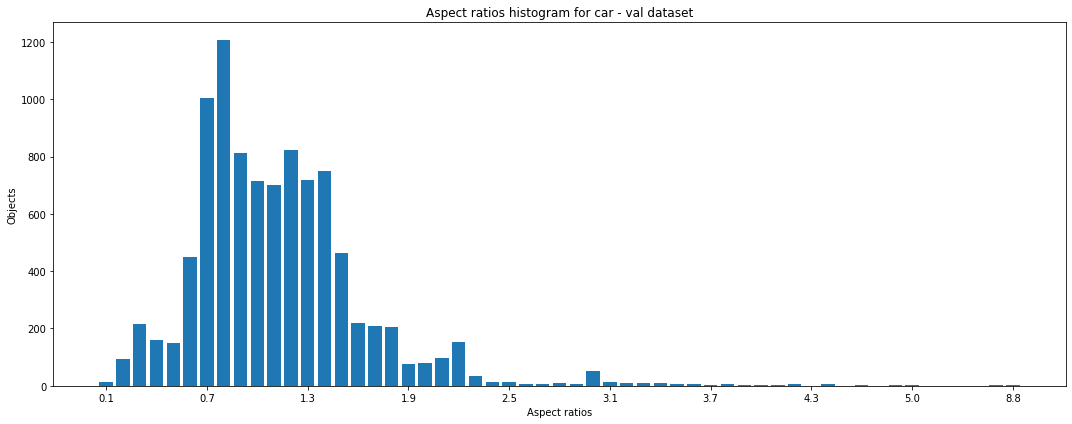

Object is: truck


<Figure size 432x288 with 0 Axes>

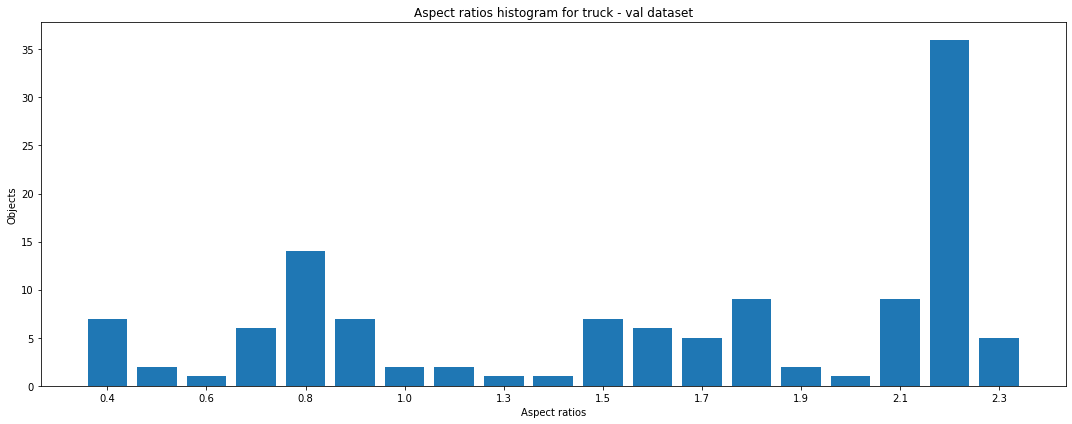

Object is: bus


<Figure size 432x288 with 0 Axes>

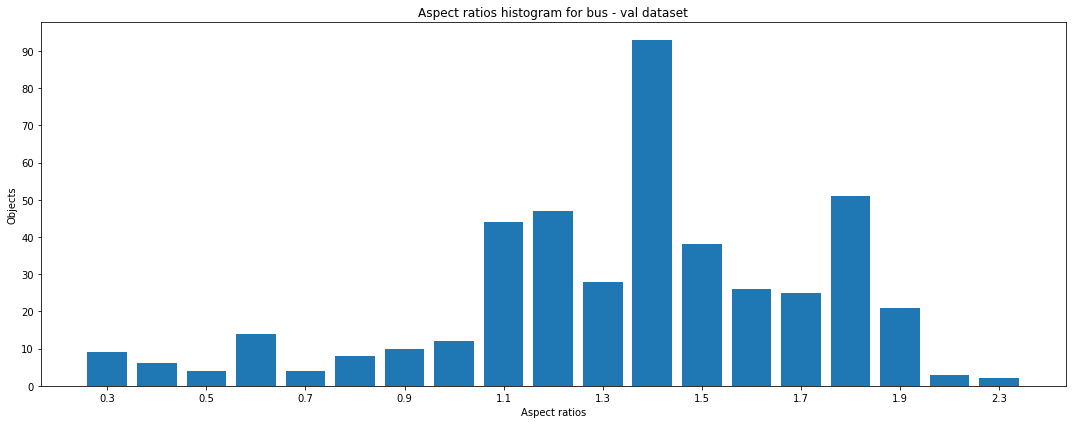

Object is: motorcycle


<Figure size 432x288 with 0 Axes>

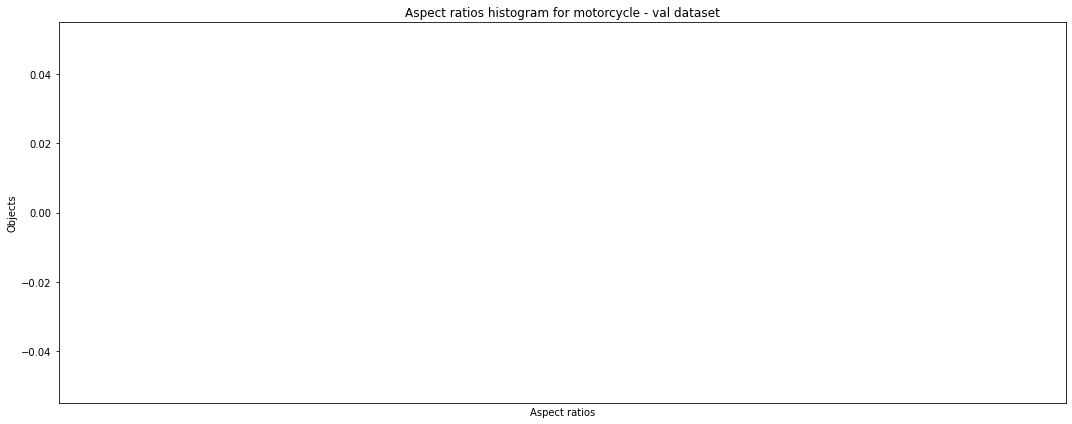

Object is: bicycle


<Figure size 432x288 with 0 Axes>

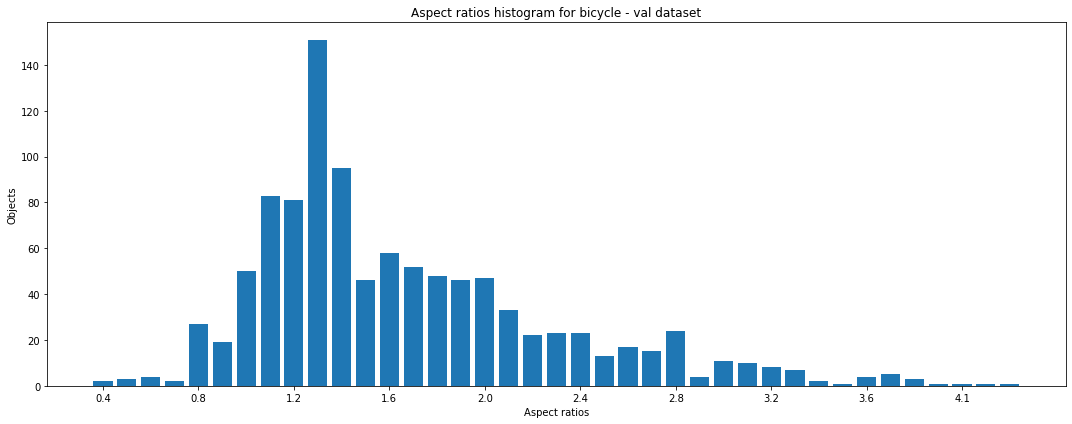

Object is: scooter


<Figure size 432x288 with 0 Axes>

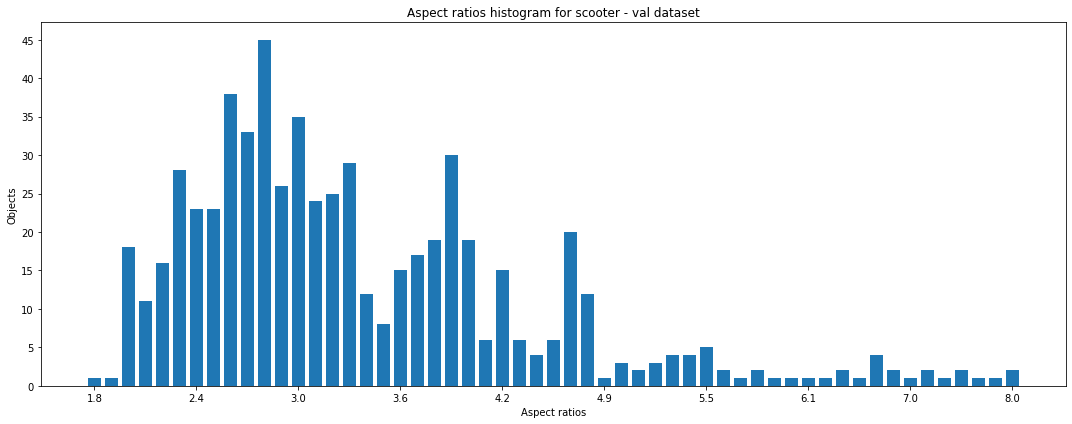

Object is: person


<Figure size 432x288 with 0 Axes>

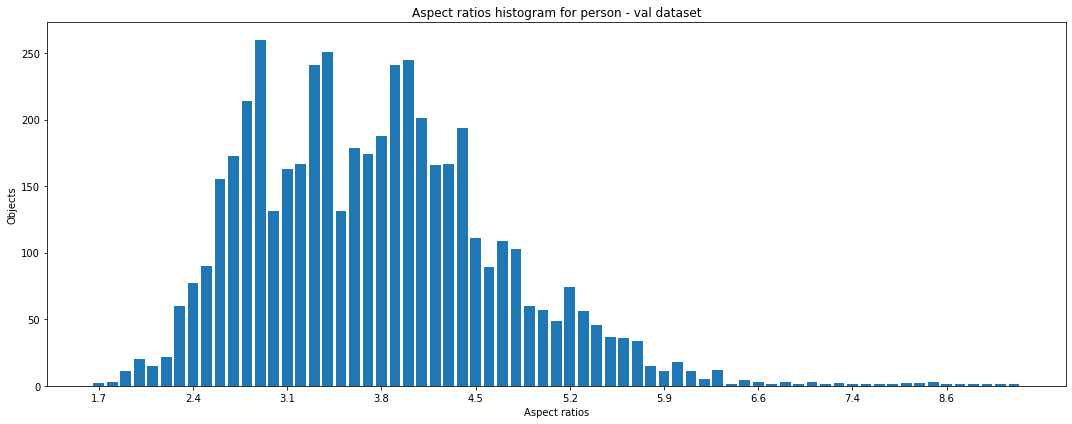

Object is: rider


<Figure size 432x288 with 0 Axes>

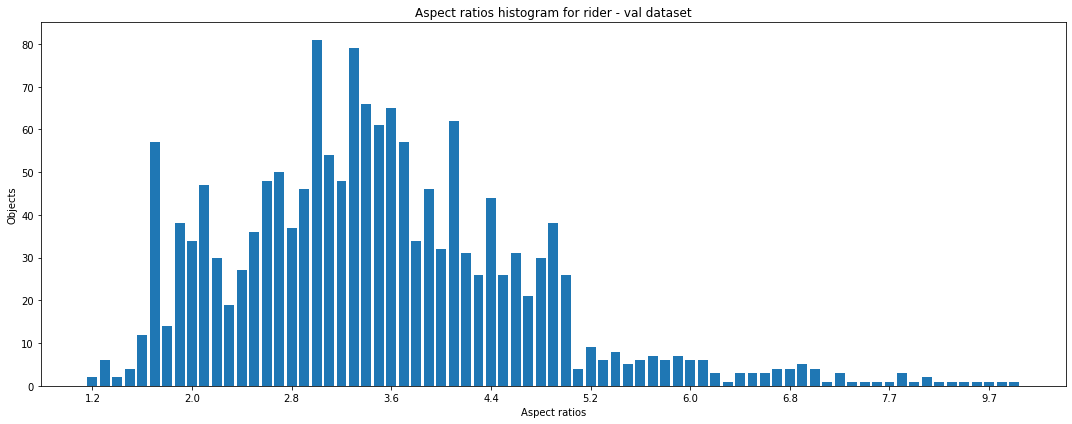

In [47]:
annotations_train = read_annotation(get_dataset_dir("tdt4265_2022/train_annotations.json"))
for category in annotations_train["categories"]:
    create_object_aspect_ratio_histogram(annotations_train, object=category["name"], dataset_to_analyze=dataset_to_analyze)

## Data annotations

In [48]:
def analyze_data_annotations(dataloader, cfg, dataset_to_analyze):
    annotations = {}
    for batch in dataloader:
        for label in batch["labels"].detach().tolist()[0]:
            try:
                annotations[cfg.label_map[label]] += 1
            except KeyError:
                annotations[cfg.label_map[label]] = 1

    total = sum(annotations.values())
    sorted_annotations = sorted(annotations.items(), key=lambda x: x[1], reverse=True)

    table = list(
        map(
            lambda x: [x[0], x[1], f"{round((x[1]/total)*100, 2)}%"],
            sorted_annotations,
        )
    )
    f = open(
        f"../dataset_exploration/tables/{dataset_to_analyze}_data_annotations.txt", "w"
    )
    f.write(tabulate(table, headers=["Object", "Occurences", "In %"]))

    print("Saved data_annotations.txt")

    create_histogram(
        annotations,
        x_label="Objects",
        y_label="Count",
        title=f"Labels distribution - {dataset_to_analyze} dataset",
        savefig_location=f"../dataset_exploration/histograms/{dataset_to_analyze}_labels_distribution.png",
        xtick_fontsize=10,
    )
    print("Saved labels_distribution.png")

Saved data_annotations.txt
Saved labels_distribution.png


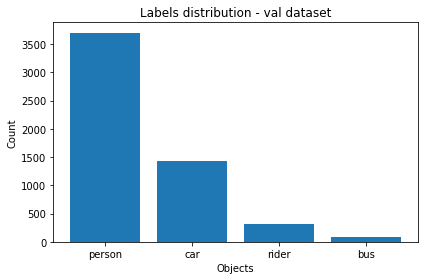

In [49]:
analyze_data_annotations(dataloader=dataloader, cfg=cfg, dataset_to_analyze=dataset_to_analyze)

## Average labels per image

In [9]:
total_labels = 0
amount = 0
for batch in dataloader:
        total_labels += len(batch["labels"].detach().tolist()[0])
        amount += 1

print(f"Average labels per image is: {total_labels/amount}")

Average labels per image is: 11.400872817955113
